In [1]:
import os
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [2]:
force_cpu = False
if not force_cpu:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Using device", device)

Using device mps


In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    root = '/content/drive/MyDrive/Colab Notebooks'
except:
    root = './'

fig_folder = f"{root}/figures"
backup_folder = f"{root}/backup"

os.listdir(root)
for f in fig_folder, backup_folder:
    os.makedirs(f, exist_ok=True)

print("Backup folder:", backup_folder)
print("Figures folder:", fig_folder)

Backup folder: .//backup
Figures folder: .//figures


In [36]:
batch_size = 256 #  Tutorial: 64
epochs = 2       #  Tutorial : 15

optim_class = torch.optim.Adam  #  Tutorial: RMSprop
optim_kwargs = dict(lr=0.01)

In [37]:
train_loader = DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False)

In [38]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = nn.Conv2d(1, 32, 3, padding="same")
        self.enc2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.enc3 = nn.Conv2d(64, 64, 3, padding="same")
        self.enc4 = nn.Conv2d(64, 64, 3, padding="same")
        self.enc5 = nn.Linear(12544, 32)

        self.dec1 = nn.Linear(2, 12544)
        self.dec2 = nn.ConvTranspose2d(64, 32, 3, stride=(2, 2), padding=1, output_padding=1)
        self.dec3 = nn.Conv2d(32, 1, 3, padding="same")

        self.mu = nn.Linear(32, 2)
        self.logvar = nn.Linear(32, 2)

    def encode(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc4(x))
        x = x.flatten(start_dim=1)
        x = F.relu(self.enc5(x))
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):

        z = F.relu(self.dec1(z))
        z = z.view(-1, 64, 14, 14)
        z = F.relu(self.dec2(z))
        x = torch.sigmoid(self.dec3(z))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [39]:
# Reconstruction + KL divergence losses summed over all elements and batch
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())

    return BCE + KLD

In [40]:
backup_file_vae = f"{backup_folder}/vae_model_no_predictor.p"
force = True
if not os.path.exists(backup_file_vae) or force:
    vae_model = VAE().to(device)
    vae_model.train()

    optimizer = optim_class(vae_model.parameters(), **optim_kwargs)

    for epoch in tqdm(range(1, epochs + 1)):

        train_loss = 0
        with tqdm(total=len(train_loader),
                  position=1, desc=f"Epoch {epoch}") as pbar:

            for batch_idx, (x, _) in enumerate(train_loader):
                x = x.to(device)
                optimizer.zero_grad()
                recon_x, mu, logvar = vae_model(x)
                loss = vae_loss(recon_x=recon_x, x=x, mu=mu, logvar=logvar)
                loss.backward()
                train_loss += loss.item()
                optimizer.step()

                train_loss += loss.item()
                pbar.update()
                pbar.set_postfix({"loss": f"{loss.item()/len(x):.4f}"})

        print('====> Epoch: {}\tAverage loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))

    torch.save(vae_model.state_dict(), backup_file_vae)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

====> Epoch: 1	Average loss: 456.2192


Epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

====> Epoch: 2	Average loss: 413.7043


In [41]:
class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.pred1 = nn.Linear(2, 128)
        self.pred2 = nn.Linear(128, 128)
        self.pred3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.pred1(x))
        x = F.relu(self.pred2(x))
        x = self.pred3(x)
        return x

In [42]:
def predictor_loss(y, pred):
    loss = nn.NLLLoss()
    return loss(torch.log_softmax(pred,  dim=1), y)

In [43]:
def combined_loss(batch,  models, vae_loss, predictor_loss, weight_pred_loss=20.):
    vae_model, predictor_model = models
    x, y = batch
    recon_x, mu, logvar = vae_model(x)
    vae_l = vae_loss(recon_x=recon_x, x=x, mu=mu, logvar=logvar)
    pred = predictor_model(mu)
    pred_l = weight_pred_loss*predictor_loss(y=y, pred=pred)
    return vae_l + pred_l

In [44]:
backup_file_vae = f"{backup_folder}/vae_model_and_classifier__vae.p"
backup_file_predictor = f"{backup_folder}/vae_model_and_classifier__classifier.p"
force = True

if not os.path.exists(backup_file_vae) or not os.path.exists(backup_file_predictor) or force:

    vae_model = VAE().to(device)
    pred_model = Predictor().to(device)
    vae_model.train()
    pred_model.train()

    optimizer = optim_class(list(vae_model.parameters())+list(pred_model.parameters()), **optim_kwargs)

    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0
        with tqdm(total=len(train_loader),
                  position=1, desc=f"Epoch {epoch}") as pbar:
            for batch_idx, batch in enumerate(train_loader):
                batch = [b.to(device) for b in batch]
                optimizer.zero_grad()
                loss = combined_loss(
                    batch=batch, models=(vae_model, pred_model),
                    predictor_loss=predictor_loss, vae_loss=vae_loss)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                pbar.update()
                pbar.set_postfix({"loss": f"{loss.item()/len(batch[0]):.4f}"})

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))


    torch.save(vae_model.state_dict(), backup_file_vae)
    torch.save(pred_model.state_dict(), backup_file_predictor)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 218.6991


Epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

====> Epoch: 2 Average loss: 168.0258


In [45]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.pred1 = nn.Linear(2, 128)
        self.pred2 = nn.Linear(128, 128)
        self.pred3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.pred1(x))
        x = F.relu(self.pred2(x))
        x = self.pred3(x)
        return x

In [51]:
def regressor_loss(y, pred):
    loss = nn.MSELoss()
    output = loss(pred.squeeze(), y.float())
    return output

In [53]:
backup_file_vae = f"{backup_folder}/vae_model_and_regressor__vae.p"
backup_file_predictor = f"{backup_folder}/vae_model_and_regressor__regressor.p"

if not os.path.exists(backup_file_vae) or not os.path.exists(backup_file_predictor):
    vae_model = VAE().to(device)
    pred_model = Regressor().to(device) # 1st change
    vae_model.train()
    pred_model.train()

    optimizer = optim_class(list(vae_model.parameters())+list(pred_model.parameters()), **optim_kwargs)

    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0
        with tqdm(total=len(train_loader),
                  position=1, desc=f"Epoch {epoch}") as pbar:
            for batch_idx, batch in enumerate(train_loader):
                batch = [b.to(device) for b in batch]
                optimizer.zero_grad()
                loss = combined_loss(
                    batch=batch, models=(vae_model, pred_model),
                    predictor_loss=regressor_loss, # 2nd change
                    vae_loss=vae_loss)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                pbar.update()
                pbar.set_postfix({"loss": f"{loss.item()/len(batch[0]):.4f}"})
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))

    torch.save(vae_model.state_dict(), backup_file_vae)
    torch.save(pred_model.state_dict(), backup_file_predictor)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 230.2772


Epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

====> Epoch: 2 Average loss: 169.2669


In [54]:
test_loader = DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=5000, shuffle=False)

x_test = None
y_test = None
for _, (x, y) in enumerate(test_loader):
    x_test = x
    y_test = y
    break

In [55]:
model_predictor_off = VAE()
model_predictor_on = VAE()
model_predictor_linear = VAE()

if not torch.cuda.is_available() and not torch.backends.mps.is_available():

    model_predictor_off.load_state_dict(torch.load(f"{backup_folder}/vae_model_no_predictor.p", map_location=torch.device('cpu')))
    model_predictor_on.load_state_dict(torch.load(f"{backup_folder}/vae_model_and_classifier__vae.p", map_location=torch.device('cpu')))
    model_predictor_linear.load_state_dict(torch.load(f"{backup_folder}/vae_model_and_regressor__vae.p", map_location=torch.device('cpu')))

else:
    model_predictor_off.load_state_dict(torch.load(f"{backup_folder}/vae_model_no_predictor.p"))
    model_predictor_on.load_state_dict(torch.load(f"{backup_folder}/vae_model_and_classifier__vae.p"))
    model_predictor_linear.load_state_dict(torch.load(f"{backup_folder}/vae_model_and_regressor__vae.p"))

In [56]:
%config InlineBackend.figure_format='retina'

In [60]:
models = {
    'VAE latent space without predictor': model_predictor_off, 
    'VAE latent space with classifier': model_predictor_on,
    'VAE latent space with regressor': model_predictor_linear}

ts = []
for model in models.values():
    model.eval()
    with torch.no_grad():
        recon_batch, mu, logvar = model(x_test)
        ts.append(mu.numpy())

if not isinstance(y_test, np.ndarray):
    y_test = y_test.numpy()

titles = list(models.keys())

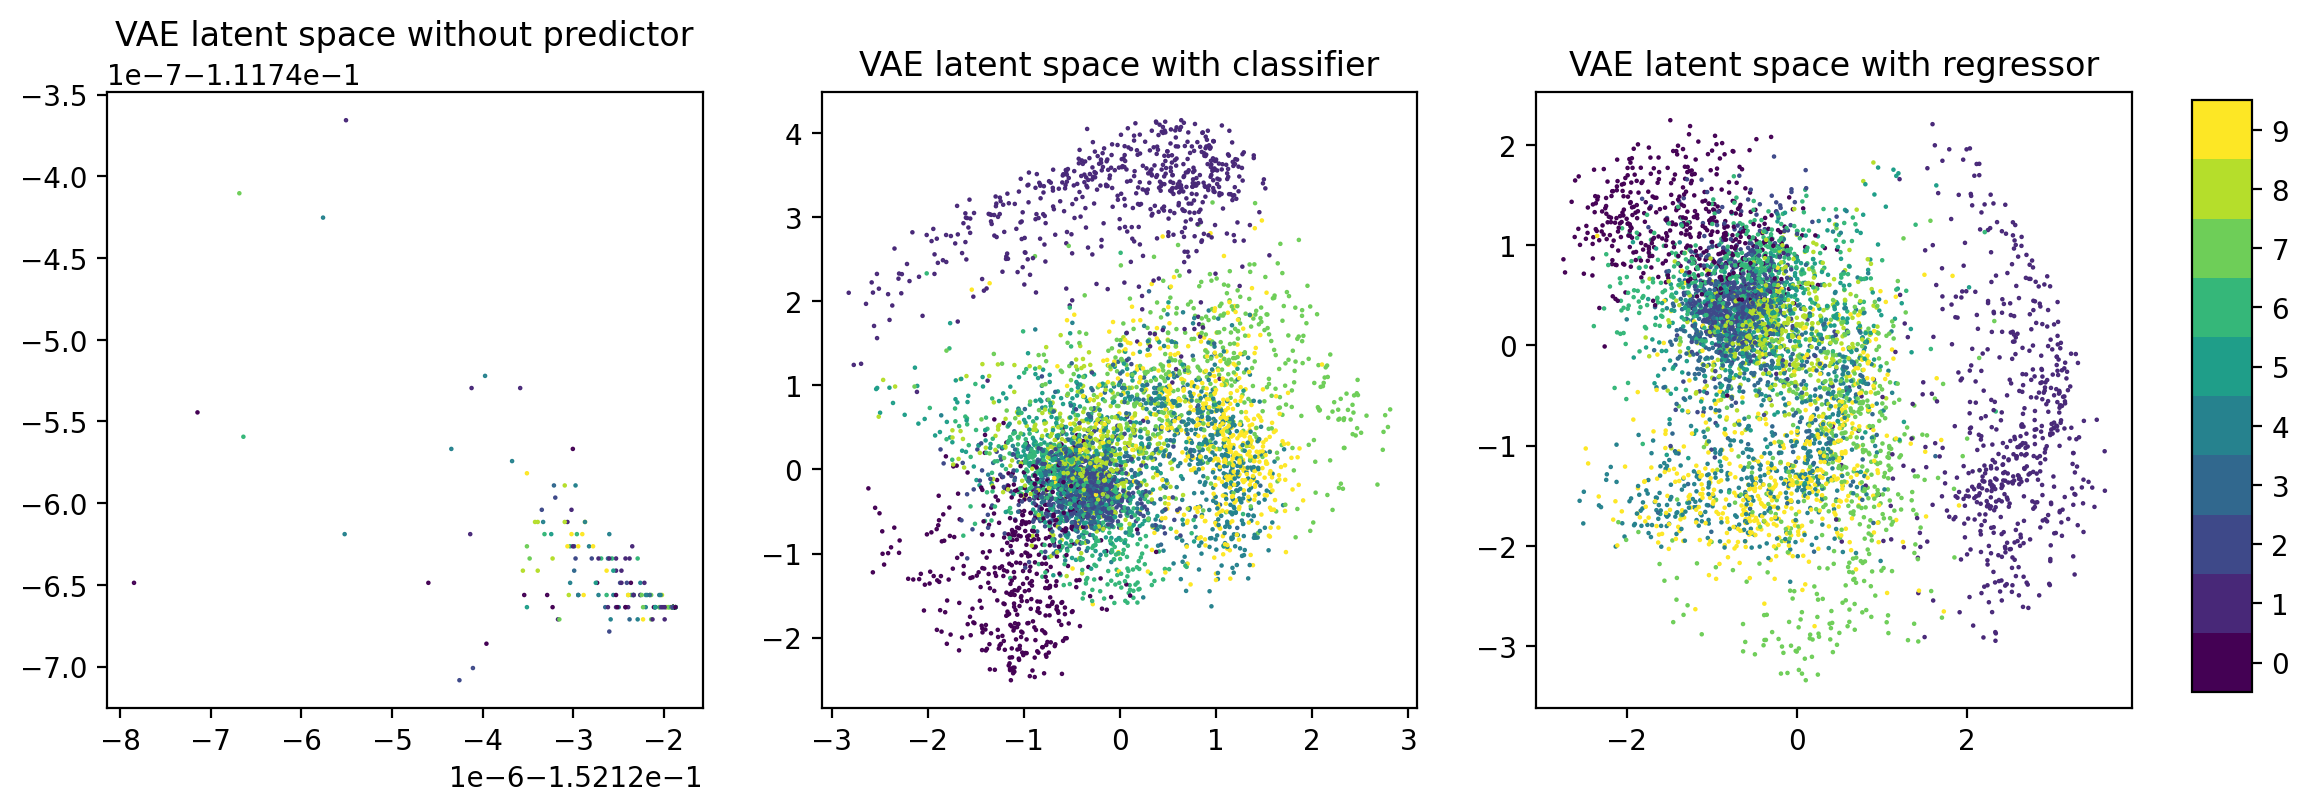

In [61]:
fig, axes = plt.subplots(ncols=len(ts), figsize=(5*len(ts), 4))
cmap = plt.get_cmap('viridis', 10)

for i, t in enumerate(ts):
    try:
        ax = axes[i]
    except TypeError:
        ax = axes

    im = ax.scatter(
        t[:, 0], t[:, 1], c=y_test,
        cmap=cmap,
        vmin=-0.5, vmax=9.5,
        marker='o', s=0.4)
    # ax.set_xlim(-4, 4)
    # ax.set_ylim(-4, 4)
    ax.set_title(titles[i])

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]), ticks=range(10));

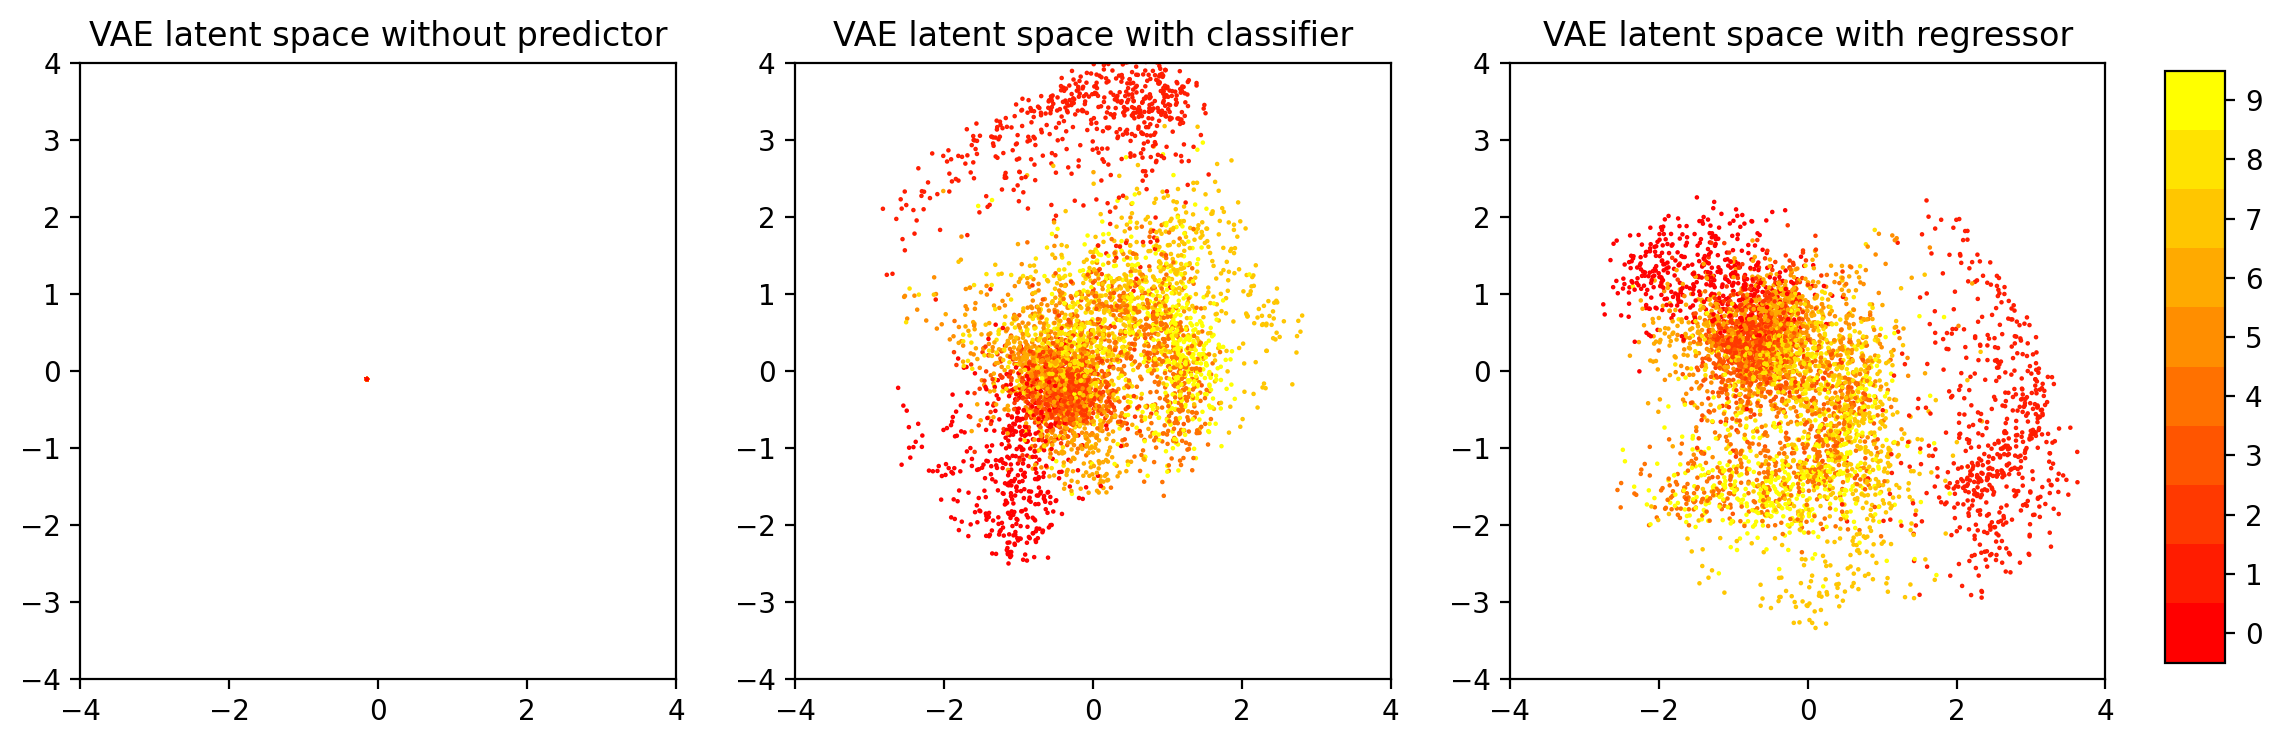

In [63]:
fig, axes = plt.subplots(ncols=len(ts), figsize=(5*len(ts), 4))
cmap = plt.get_cmap('autumn', 10)

for i, t in enumerate(ts):
    try:
        ax = axes[i]
    except TypeError:
        ax = axes

    im = ax.scatter(
        t[:, 0], t[:, 1], c=y_test,
        cmap=cmap,
        vmin=-0.5, vmax=9.5,
        marker='o', s=0.4)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_title(titles[i])

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]), ticks=range(10));

In [67]:
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal

def nll_predict(i):
    '''Optimization objective based on predictor output.'''
    return nll_prior - np.log(y_flat[:,i] + 1e-8).reshape(-1, 1)

def plot_nll(gx, gy, nll):
    fig = plt.figure(figsize=(15, 6))
    plt.subplots_adjust(hspace=0.4)

    for i in range(10):
        plt.subplot(2, 5, i+1)
        gz = nll(i).reshape(gx.shape)
        im = plt.contourf(gx, gy, gz, 
                          cmap='coolwarm', 
                          norm=LogNorm(), 
                          levels=np.logspace(0.2, 1.8, 100))
        plt.title(f'Target = {i}')
        plt.xlim(-4, 4)
        plt.ylim(-4, 4)
    
    fig.subplots_adjust(right=0.8)
    fig.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]), 
                 ticks=np.logspace(0.2, 1.8, 11), format='%.2f', 
                 label='Negative log likelihood')

torch.Size([6400, 2])


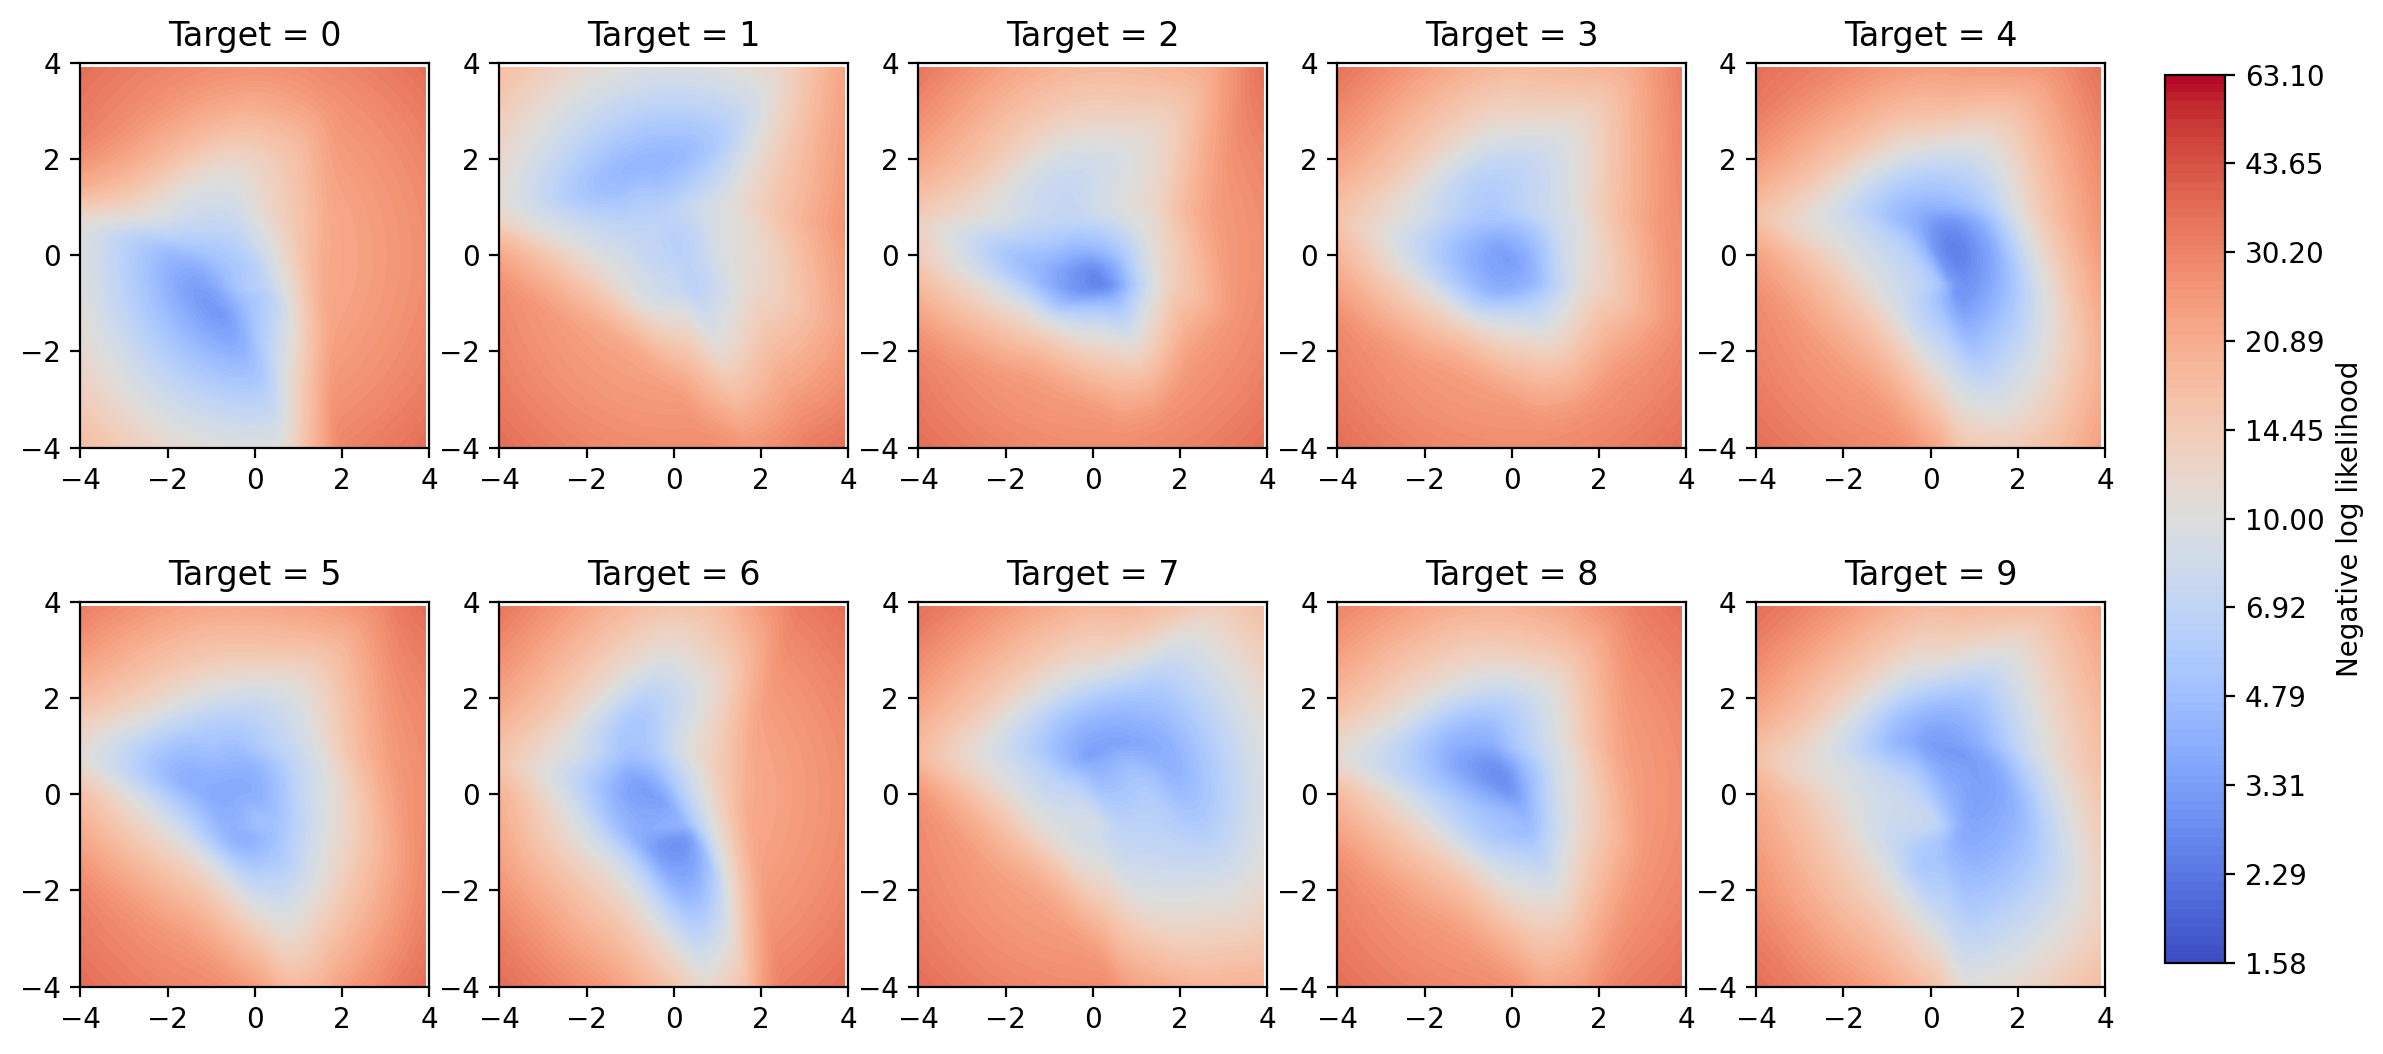

In [68]:
class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.pred1 = nn.Linear(2, 128)
        self.pred2 = nn.Linear(128, 128)
        self.pred3 = nn.Linear(128, 10)

    def forward(self, x):
        print(x.shape)
        x = F.relu(self.pred1(x))
        x = F.relu(self.pred2(x))
        x = self.pred3(x)
        return x

predictor = Predictor()
predictor.load_state_dict(torch.load(f"{backup_folder}/vae_model_and_classifier__classifier.p", map_location=device))

rx, ry = np.arange(-4, 4, 0.10), np.arange(-4, 4, 0.10)
gx, gy = np.meshgrid(rx, ry)

t_flat = np.c_[gx.ravel(), gy.ravel()]
t_flat = torch.from_numpy(t_flat).float()
with torch.no_grad():
    logits = predictor(t_flat)
y_flat = torch.softmax(logits, dim=1).numpy()

mvn = multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]])
nll_prior = -mvn.logpdf(t_flat).reshape(-1, 1)

plot_nll(gx, gy, nll_predict)